In [1]:
import numpy as np
# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from multihist import Histdd
from matplotlib.colors import LogNorm
plt.rcParams.update({'font.size': 18})

In [2]:
import straxen
st = straxen.contexts.strax_workshop_dali()

In [3]:
straxen.download_test_data()

In [4]:
dsets = st.select_runs(include_tags='sciencerun2_preliminary', 
                       exclude_tags='?fterNG',
                       available='raw_records', 
                       run_mode='background*')
len(dsets)
n_runs = 5
dsets_sample = dsets.head(n_runs)
run_ids = dsets_sample.name.values.tolist()
run_ids = ['180215_1029']

Checking data availability: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


In [5]:
import strax
import numba

@strax.takes_config(
    strax.Option('tight_coincidence_window_left', default=50,
                 help="Time range left of peak center to call a hit a tight coincidence (ns)"),
    strax.Option('tight_coincidence_window_right', default=50,
                 help="Time range right of peak center to call a hit a tight coincidence (ns)"),
)
class TightCoincidence(strax.Plugin):
    """Calculates the tight coincidence"""
    
    # Name of the data type this plugin provides
    provides = 'tight_coincidence'
    data_kind = 'peaks'
    
    depends_on = ('records', 'peaks')
    
    # Numpy datatype of the output 
    dtype = [
        (('Hits within tight range of mean', 'tight_coincidence'), np.int16),
    ]
    
    # Version of the plugin. Increment this if you change the algorithm.
    __version__ = '0.0.1'
        
    #parallel = 'process'
    #rechunk_on_save = True
    
    @staticmethod
    @numba.jit(nopython=True, nogil=True, cache=True)
    def get_tight_coin(hit_mean_times, peak_mean_times, left, right):
        left_hit_i = 0
        n_coin = np.zeros(len(peak_mean_times), dtype=np.int16)
        
        # loop over peaks
        for p_i, p_t in enumerate(peak_mean_times):
            
            # loop over hits starting from the last one we left at
            for left_hit_i in range(left_hit_i, len(hit_mean_times)):
                
                # if the hit is in the window, its a tight coin
                if (
                    (p_t - hit_mean_times[left_hit_i] < left)
                    & (hit_mean_times[left_hit_i] - p_t < right)
                ):
                    n_coin[p_i] += 1
                    
                # stop the loop when we know we're outside the range
                if (hit_mean_times[left_hit_i] - p_t > right):
                    break
                    
        return n_coin


    def compute(self, records, peaks):
        r = records
        p = peaks
        hits = strax.find_hits(r)
        hits = strax.sort_by_time(hits)
        
        hit_mean_times = hits['time'] + (hits['length']/2.0)  # hit "mean" time
        peak_mean_times = p['time'] + (p['length']/2.0)  # peak "mean" time
        
        tight_coin = self.get_tight_coin(
            hit_mean_times, 
            peak_mean_times, 
            self.config['tight_coincidence_window_left'], 
            self.config['tight_coincidence_window_right']
        )
        
        return dict(tight_coincidence=tight_coin)

In [6]:
st2 = st.new_context(config=dict(
    tight_coincidence_window_left = 50,
    tight_coincidence_window_right = 50,
))
st2.register(TightCoincidence)

__main__.TightCoincidence

In [7]:
peak_data_tight_coin = st2.get_array(run_ids, ['peaks', 'peak_basics', 'peak_classification', 'tight_coincidence'])

In [8]:
peak_data_tight_coin.dtype.names

('channel',
 'dt',
 'time',
 'length',
 'area',
 'area_per_channel',
 'n_hits',
 'data',
 'width',
 'saturated_channel',
 'n_saturated_channels',
 'endtime',
 'n_channels',
 'max_pmt',
 'max_pmt_area',
 'range_50p_area',
 'area_fraction_top',
 'type',
 'tight_coincidence')

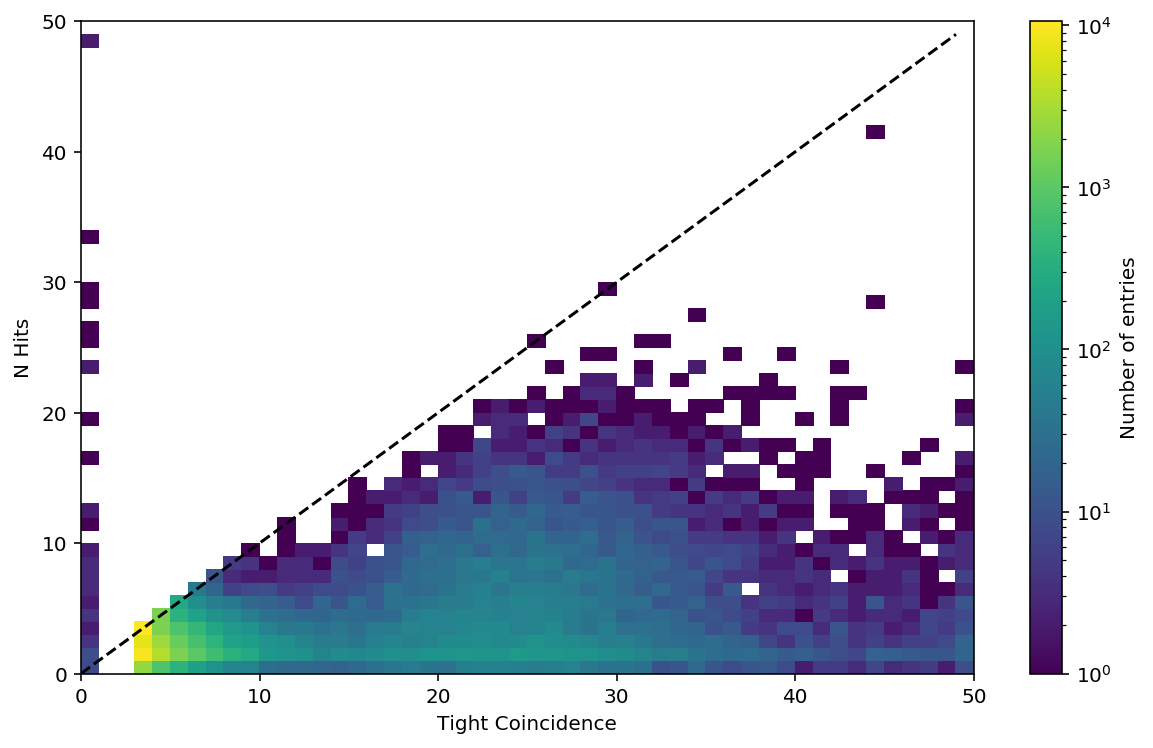

In [9]:


plt.figure(figsize=(10,6))
mh = Histdd(peak_data_tight_coin['n_hits'], peak_data_tight_coin['tight_coincidence'], bins=(50,50), range=((0,50),(0,50)))

mh.plot(norm=LogNorm())
plt.plot(range(50), range(50), 'k--')
plt.xlabel('Tight Coincidence')
plt.ylabel('N Hits')
plt.show()

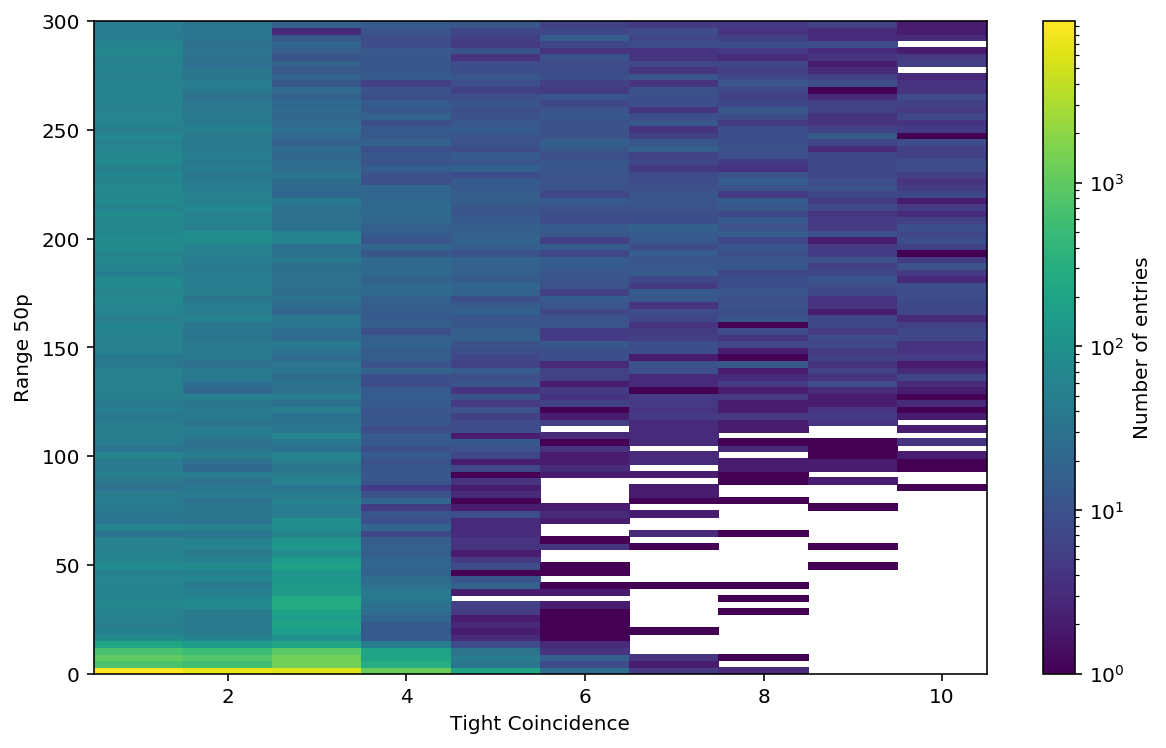

In [10]:
plt.figure(figsize=(10,6))
xrange = (0.5, 10.5)

mh = Histdd(
    peak_data_tight_coin['tight_coincidence'], 
    peak_data_tight_coin['width'][:,5], 
    bins=(xrange[1]-xrange[0],100), 
    range=(xrange,(0, 300))
)
mh.plot(norm=LogNorm())

plt.xlabel('Tight Coincidence')
plt.ylabel('Range 50p')
plt.show()

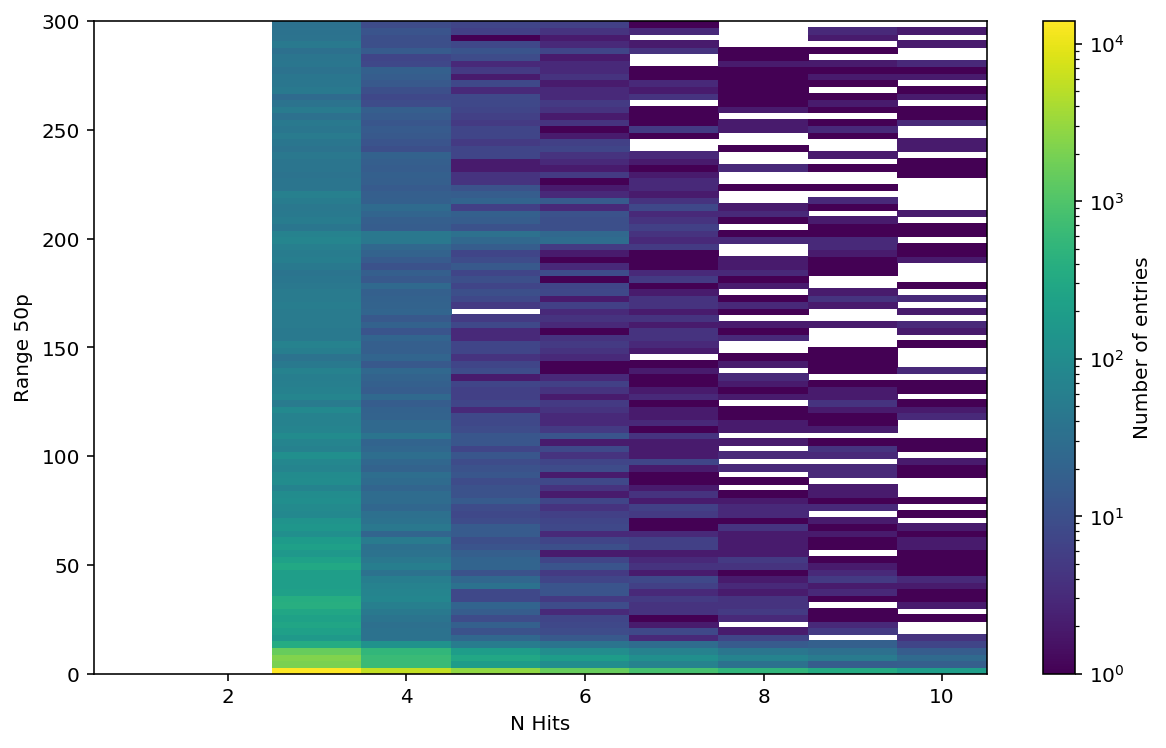

In [11]:
plt.figure(figsize=(10,6))

xrange = (0.5, 10.5)
mh = Histdd(
    peak_data_tight_coin['n_hits'], 
    peak_data_tight_coin['width'][:,5], 
    bins=(xrange[1]-xrange[0],100), 
    range=(xrange,(0, 300))
)
mh.plot(norm=LogNorm())

plt.xlabel('N Hits')
plt.ylabel('Range 50p')
plt.show()

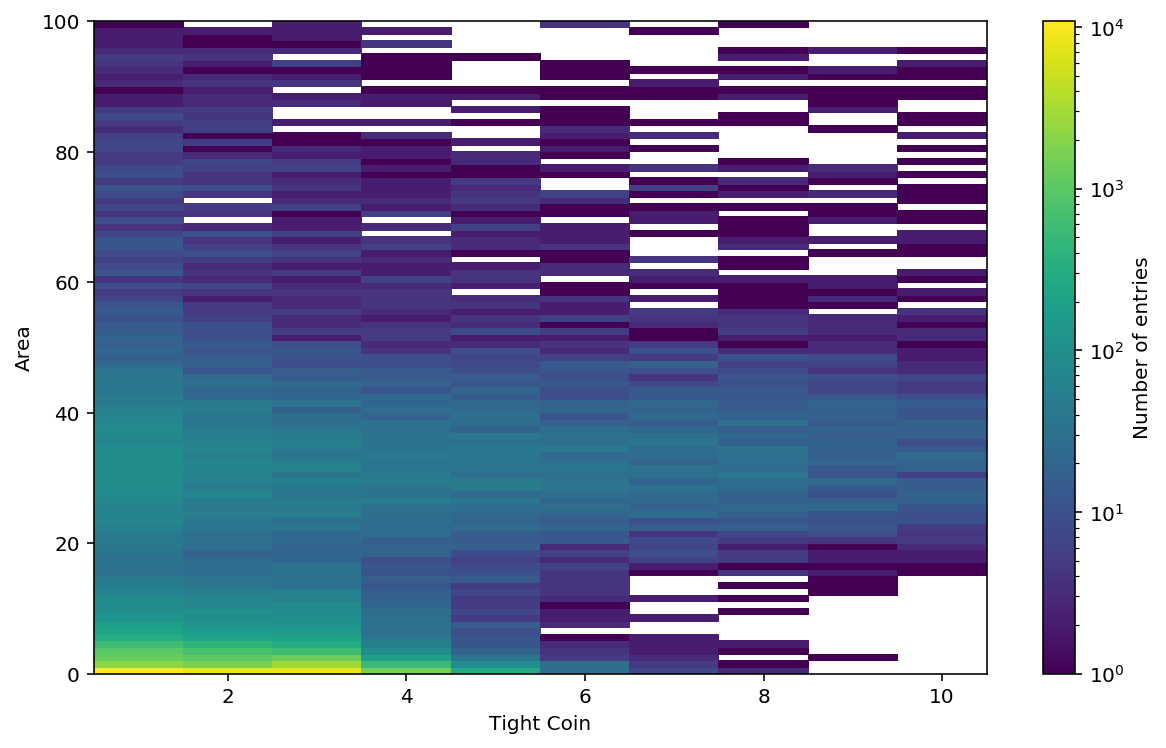

In [12]:
plt.figure(figsize=(10,6))

xrange = (0.5, 10.5)
mh = Histdd(
    peak_data_tight_coin['tight_coincidence'], 
    peak_data_tight_coin['area'], 
    bins=(xrange[1]-xrange[0],100), 
    range=(xrange,(0, 100))
)
mh.plot(norm=LogNorm())

plt.xlabel('Tight Coin')
plt.ylabel('Area')
plt.show()

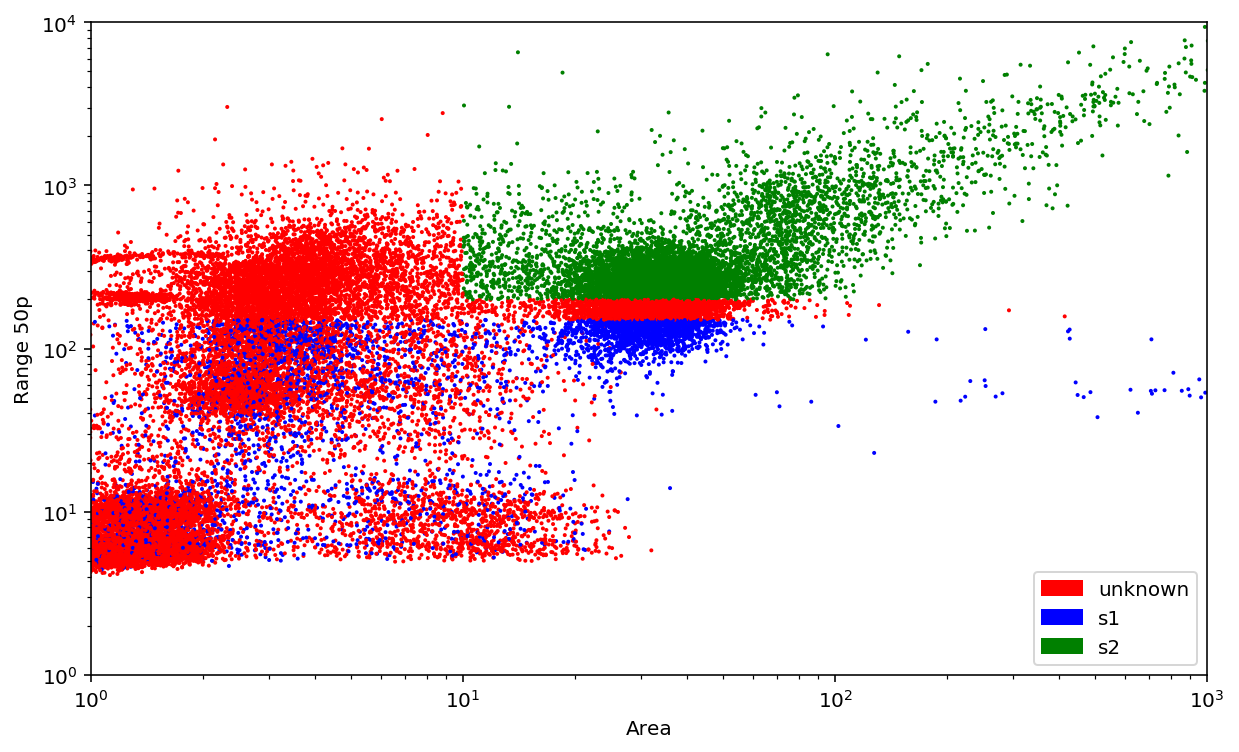

In [13]:
peak_data_coin = peak_data_tight_coin

import matplotlib.patches as mpatches
colors = ['r','b','g']
fig = plt.figure(figsize=(10,6))
plt.scatter(peak_data_coin['area'], peak_data_coin['width'][:,5], c=[colors[i] for i in peak_data_coin['type']], s=1)
labels = ['unknown', 's1', 's2']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')

plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e3])
plt.ylim([1, 1e4])
plt.xlabel('Area')
plt.ylabel('Range 50p')
plt.show()

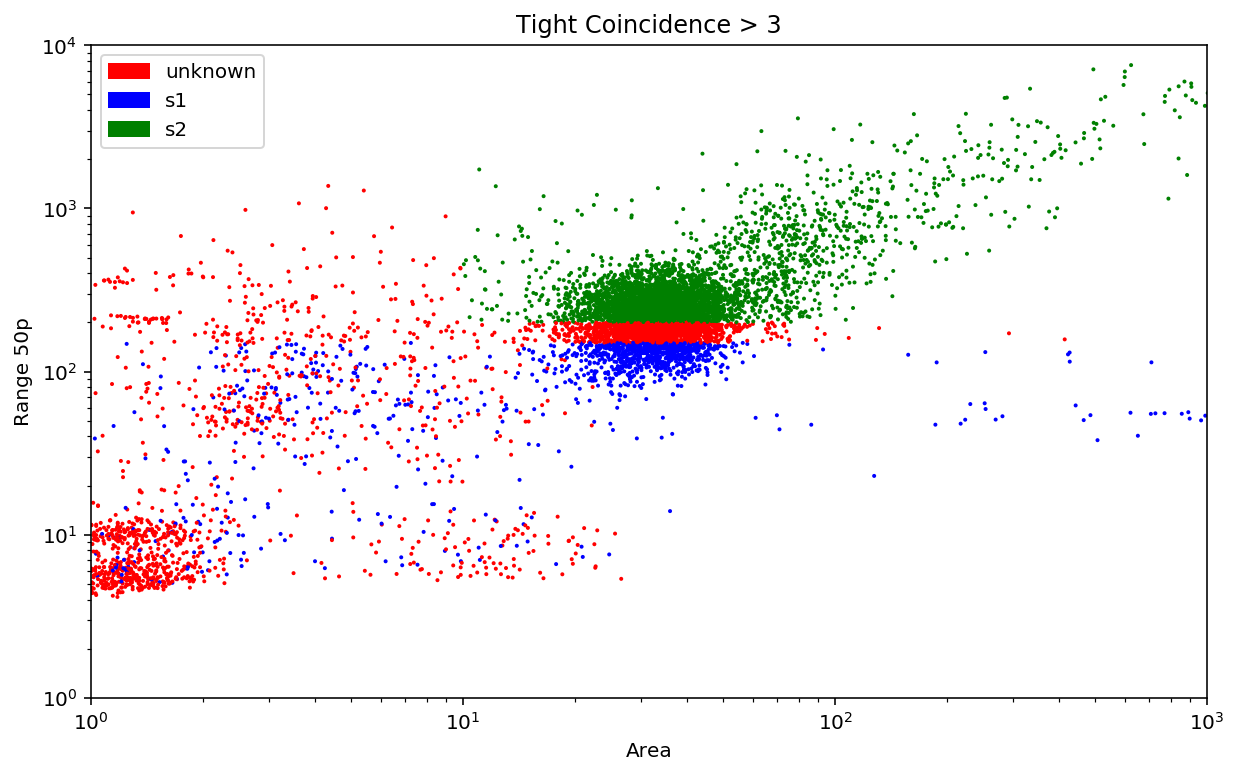

In [14]:
peak_data_coin = peak_data_tight_coin[peak_data_tight_coin['tight_coincidence'] > 3]

colors = ['r','b','g']
fig = plt.figure(figsize=(10,6))
plt.scatter(peak_data_coin['area'], peak_data_coin['width'][:,5], c=[colors[i] for i in peak_data_coin['type']], s=1)
labels = ['unknown', 's1', 's2']

p0 = mpatches.Patch(color=colors[0], label='unknown')
p1 = mpatches.Patch(color=colors[1], label='s1')
p2 = mpatches.Patch(color=colors[2], label='s2')

plt.legend(handles=[p0, p1, p2], labels=['unknown', 's1', 's2'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([1, 1e3])
plt.ylim([1, 1e4])
plt.xlabel('Area')
plt.ylabel('Range 50p')
plt.title('Tight Coincidence > 3')
plt.show()